<a href="https://colab.research.google.com/github/newton143/Business_Forecasting_Project/blob/main/DS_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#!/usr/bin/python

import numpy as np
from scipy.stats import bernoulli, norm
import matplotlib.pyplot as plt

In [25]:
def loglikelihood(p, values):
    n = len(values)
    k = np.sum(values)  # Number of successes
    # The log-likelihood for Bernoulli is log(p)^k * log(1-p)^(n-k), which simplifies to k*log(p) + (n-k)*log(1-p).
    result = k * np.log(p) + (n - k) * np.log(1 - p)
    return result

In [26]:
def normal_mu_loglikelihood(mu, values):
    # The log-likelihood for Normal is -n/2 * log(2*pi*sigma^2) - 1/(2*sigma^2) * sum((values - mu)^2)
    # Since sigma is assumed constant, we only need to consider the term that depends on mu,
    # which is -sum((values - mu)^2). Maximizing this is equivalent to minimizing sum((values - mu)^2).
    result = -np.sum((values - mu) ** 2)
    return result

In [27]:
def normal_sigma_loglikelihood(sigma, values, mu):
    n = len(values)
    # The log-likelihood for Normal is -n/2 * log(2*pi*sigma^2) - 1/(2*sigma^2) * sum((values - mu)^2)
    # This can be simplified to -n * log(sigma) - sum((values - mu)^2) / (2 * sigma**2) - (n/2)*log(2*np.pi)
    # The last term is constant with respect to sigma, so we can ignore it for optimization.
    result = -n * np.log(sigma) - np.sum((values - mu) ** 2) / (2 * sigma ** 2)
    return result

In [28]:
def numerical_derivative(func, values, param, h=1e-4):
    # Approximate derivative using the forward finite difference method.  f'(x) ≈ (f(x+h) - f(x)) / h
    result = (func(param + h, values) - func(param, values)) / h
    return result

In [29]:
def errorHandler(f, param, values):
    # Safely evaluate a function. If it fails, return -∞ instead of crashing.
    with np.errstate(all='raise'):
        try:
            return f(param, values)
        except:
            return float('-inf')

In [30]:
def univariant_gradient_descent(obj_function, values, initial_guess, mu=None):
    tolerance = 1e-4  # Convergence criterion: stop when the improvement is small
    param = initial_guess
    # Test different learning rates (step sizes) to find the best step in each iteration
    step_sizes = [1e-6, 1e-3, 0.1, 20]
    last_score = float('-inf') # Keep track of the log-likelihood from the previous step

    print(f"Starting Gradient Descent with initial guess: {initial_guess:.4f}")

    while True:
        # Calculate the gradient (approximate derivative) of the objective function
        # at the current parameter value using numerical differentiation.
        # The lambda function handles passing 'mu' if it's provided for sigma estimation.
        grad = numerical_derivative(
            (lambda x, vals: obj_function(x, vals) if mu is None else obj_function(x, vals, mu)),
            values, param
        )

        # Generate candidate parameter updates by taking steps in the direction of the gradient
        # using different step sizes.
        candidates = [param + grad * step for step in step_sizes]

        # Evaluate the objective function (log-likelihood) for each candidate parameter
        # using safe_eval to handle potential errors for invalid parameter values (e.g., sigma <= 0).
        scores = [(candidate, errorHandler(
                (lambda y, vals: obj_function(y, vals) if mu is None else obj_function(y, vals, mu)),
                candidate, values
            )) for candidate in candidates]

        # Filter out candidates that resulted in -inf (invalid parameter values)
        # and find the valid candidate with the highest objective function score.
        valid_scores = [(c, s) for c, s in scores if s > float('-inf')]
        if not valid_scores:
            print("No valid candidates found. Stopping gradient descent.")
            return param # Return the last valid parameter if no improvement is possible

        # Find the candidate parameter that gives the maximum log-likelihood score among valid candidates
        next_param, next_score = max(valid_scores, key=lambda item: item[1])

        print(f"Current Estimate: {next_param:.4f}, Log-Likelihood: {next_score:.4f}")

        # Check for convergence: if the improvement in the log-likelihood from the last step
        # is very small, we consider the algorithm to have converged.
        if abs(next_score - last_score) < tolerance:
            print("Convergence reached.")
            return param  # Return the parameter from the previous step as the best estimate

        # If not converged, update the current parameter and last score for the next iteration
        param, last_score = next_param, next_score

In [31]:
def plot(obj_function, values, param_range, estimate, true_value=None, mu=None, title=""):
    xs = np.linspace(param_range[0], param_range[1], 200)
    # Create a lambda function that correctly calls the objective function, passing mu if needed
    func_to_plot = lambda x: obj_function(x, values) if mu is None else obj_function(x, values, mu)
    ys = [errorHandler(func_to_plot, x, values) for x in xs]

    plt.figure(figsize=(7, 4))
    plt.plot(xs, ys, label="Log-Likelihood")
    plt.axvline(estimate, color='red', linestyle='--', label=f"Estimate = {estimate:.2f}")
    if true_value is not None:
        plt.axvline(true_value, color='green', linestyle=':', label=f"True = {true_value:.2f}")
    plt.title(title)
    plt.xlabel("Parameter")
    plt.ylabel("Log-Likelihood")
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
# Generate 100,000 samples from a Bernoulli distribution with parameter p = 0.2
sample_data = bernoulli.rvs(0.2, size=100000)

# Generate 100,000 samples from a Normal distribution with mean = 2 and standard deviation = 3
normal_sample_data = norm.rvs(loc=2, scale=3, size=100000)

In [36]:
# Bernoulli
est_p = univariant_gradient_descent(loglikelihood, sample_data, 0.5)
print("True p:", 0.2, "| Estimated p:", est_p, "| Sample Mean:", np.mean(sample_data))





Starting Gradient Descent with initial guess: 0.5000
Current Estimate: 0.3800, Log-Likelihood: -57604.1467
Current Estimate: 0.3037, Log-Likelihood: -52802.1714
Current Estimate: 0.2547, Log-Likelihood: -50885.5095
Current Estimate: 0.2259, Log-Likelihood: -50255.2550
Current Estimate: 0.2112, Log-Likelihood: -50096.5501
Current Estimate: 0.2045, Log-Likelihood: -50065.5551
Current Estimate: 0.2018, Log-Likelihood: -50060.4964
Current Estimate: 0.2007, Log-Likelihood: -50059.7554
Current Estimate: 0.2003, Log-Likelihood: -50059.6561
Current Estimate: 0.2002, Log-Likelihood: -50059.6449
Current Estimate: 0.2001, Log-Likelihood: -50059.6444
Current Estimate: 0.2001, Log-Likelihood: -50059.6448
Current Estimate: 0.2001, Log-Likelihood: -50059.6450
Current Estimate: 0.2001, Log-Likelihood: -50059.6451
Convergence reached.
True p: 0.2 | Estimated p: 0.20009485081551254 | Sample Mean: 0.20014


In [37]:
# Normal Mean Estimation
est_mu = univariant_gradient_descent(normal_mu_loglikelihood, normal_sample_data, initial_guess=0)
print("True mu:", 2, "| Estimated mu:", est_mu, "| Sample Mean:", np.mean(normal_sample_data))


--- Normal Mean Estimation ---
Starting Gradient Descent with initial guess: 0.0000
Current Estimate: 0.4013, Log-Likelihood: -1152415.5238
Current Estimate: 0.7223, Log-Likelihood: -1059657.9988
Current Estimate: 0.9791, Log-Likelihood: -1000292.6692
Current Estimate: 1.1846, Log-Likelihood: -962298.4473
Current Estimate: 1.3490, Log-Likelihood: -937981.8166
Current Estimate: 1.4805, Log-Likelihood: -922418.9099
Current Estimate: 1.5857, Log-Likelihood: -912458.4393
Current Estimate: 1.6698, Log-Likelihood: -906083.5698
Current Estimate: 1.7371, Log-Likelihood: -902003.5186
Current Estimate: 1.7910, Log-Likelihood: -899392.1782
Current Estimate: 1.8341, Log-Likelihood: -897720.8341
Current Estimate: 1.8686, Log-Likelihood: -896651.1049
Current Estimate: 1.8961, Log-Likelihood: -895966.4231
Current Estimate: 1.9182, Log-Likelihood: -895528.1827
Current Estimate: 1.9358, Log-Likelihood: -895247.6735
Current Estimate: 1.9500, Log-Likelihood: -895068.1193
Current Estimate: 1.9613, Log-Li

Starting Gradient Descent with initial guess: 1.0000
Current Estimate: 1.7946, Log-Likelihood: -197386.9944
Current Estimate: 1.8937, Log-Likelihood: -188606.3386
Current Estimate: 1.9726, Log-Likelihood: -182905.3976
Current Estimate: 2.0385, Log-Likelihood: -178880.5806
Current Estimate: 2.0951, Log-Likelihood: -175882.7010
Current Estimate: 2.1446, Log-Likelihood: -173564.2770
Current Estimate: 2.1887, Log-Likelihood: -171720.5387
Current Estimate: 2.2283, Log-Likelihood: -170222.2170
Current Estimate: 2.2643, Log-Likelihood: -168983.3505
Current Estimate: 2.2972, Log-Likelihood: -167944.3975
Current Estimate: 2.3275, Log-Likelihood: -167062.7355
Current Estimate: 2.3555, Log-Likelihood: -166307.0141
Current Estimate: 2.3815, Log-Likelihood: -165653.6411
Current Estimate: 2.4057, Log-Likelihood: -165084.5140
Current Estimate: 2.4284, Log-Likelihood: -164585.5076
Current Estimate: 2.4497, Log-Likelihood: -164145.4373
Current Estimate: 2.4698, Log-Likelihood: -163755.3321
Current Esti

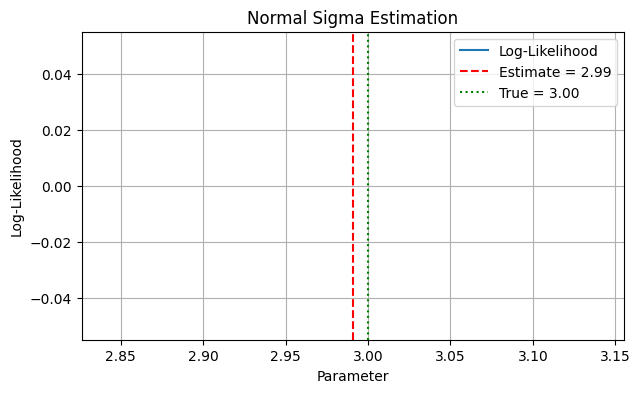

In [38]:
# Normal Sigma Estimation
est_sigma = univariant_gradient_descent(normal_sigma_loglikelihood, normal_sample_data, initial_guess=1, mu=est_mu)
print("True sigma:", 3, "| Estimated sigma:", est_sigma, "| Sample Std:", np.std(normal_sample_data))
plot(normal_sigma_loglikelihood, normal_sample_data, (0.1, 6), est_sigma, true_value=3, mu=est_mu, title="Normal Sigma Estimation")